In [1]:
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft, fftfreq
import numpy as np

from afc_prep import full_waveform
from afc_prep import full_waveform_noshift

In [2]:
def reverse_sin_fit(amp):
    a = 0.57864009
    w = 0.86398453
    return np.arcsin(amp / a) / w

In [37]:
# device params
samp_rate = 2.4e9  # unit: Hz
volt_range = 5  # unit: V

# EOM params
Vpi = 4.25  # unit: V

# waveform params
A = Vpi / (volt_range * np.pi)  # overall amplitude of pulse (after normalization)
N = 2
delta = 1e6  # unit: Hz
tau = 2e-3  # unit: s
beta = 10 / tau
delta_f = 0.7e6  # unit: Hz
f_0 = 240e6  # unit: Hz
f_light = 195e12  # light frequency (in Hz)

resolution = 1 / samp_rate  # unit: s
num_points = tau / resolution
num_points = (num_points // 16) * 16  # round to multiple of 16

t, theta, amp = (
    full_waveform(N, delta, num_points, resolution, beta, f_light, delta_f))

In [38]:
# for testing
DETUNING = 1.0
Vpi = Vpi * DETUNING

coeff = amp / (volt_range * np.max(amp))
# coeff = amp / volt_range
coeff_sin = (1 / volt_range) * reverse_sin_fit(amp * .5 / np.max(amp))
conversion = np.pi * volt_range / Vpi  # convert from voltage to radians
wav = ((A * theta) * conversion +
       coeff * conversion * np.sin(2 * np.pi * f_0 * t))  # V(t)
wav_sin = ((A * theta) * conversion +
           coeff_sin * conversion * np.sin(2 * np.pi * f_0 * t))  # V(t)
wav_no_side = ((A * theta) * conversion)

In [39]:
# actual wave to transform
w0 = 100e6
y = np.sin(wav + w0 * t * np.pi * 2)
y_sin = np.sin(wav_sin + w0 * t * np.pi * 2)
y_no_side = np.sin(wav_no_side + w0 * t * np.pi * 2)

# determine FFT
num_points = int(num_points)
T = resolution
yf = fft(y)
yf_sin = fft(y_sin)
yf_no_side = fft(y_no_side)
xf = fftfreq(num_points, T)[:num_points//2] * 1e-6

# scale and average
yf_to_plot = 2.0 / num_points * np.abs(yf[0:num_points//2])

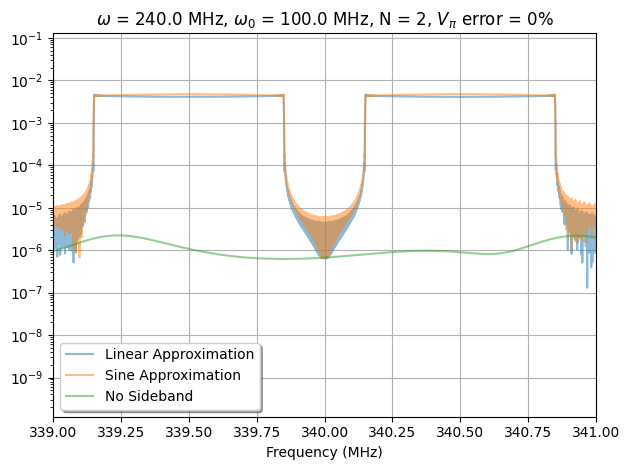

In [41]:
center = (f_0 + w0) / 1e6  # center of plot (MHz)
# width = (delta / 1e6) * N  # MHz
width = 2*delta / 1e6

fig, ax = plt.subplots()

ax.plot(xf, yf_to_plot,
        alpha=0.5, label='Linear Approximation')
ax.plot(xf, 2.0 / num_points * np.abs(yf_sin[0:num_points // 2]),
        alpha=0.5, label='Sine Approximation')
ax.plot(xf, 2.0 / num_points * np.abs(yf_no_side[0:num_points // 2]),
        alpha=0.5, label='No Sideband')
ax.set_yscale('log')

ax.set_title(rf"$\omega$ = {f_0//1e6} MHz, $\omega_0$ = {w0//1e6} MHz, N = {N}, $V_\pi$ error = {DETUNING - 1:.0%}")
ax.set_xlabel('Frequency (MHz)')
ax.set_xlim(center-width/2, center+width/2)
# ax.set_ylim((0, 0.001))
ax.legend(shadow=True)
ax.grid()

plt.tight_layout()
plt.show()